In [1]:
from transformer_payne import TransformerPayne
import matplotlib.pyplot as plt
import numpy as np

The model will be downloaded from the HuggingFace hub if it wasn't found in the passed cache directory (default=```'.cache'```).

In [2]:
model = TransformerPayne.download()

/Users/tr/repos/transformer_payne/src/transformer_payne/transformer_payne.py:121: UserWarning: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte Downloading the model from HuggingFace.
  warnings.warn(str(e) + " Downloading the model from HuggingFace.")
/Users/tr/opt/anaconda3/envs/transformer_payne/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is all you need! You can now work with spectra by passing in the:
- logarithms of wavelengths in [log($\AA$)]
- spectral parameter values (refer to ```model.parameter_names```)
- $\mu$ - cosine of the angle between the radius and the line-of-sight

In [3]:
log_wave = np.linspace(np.log10(4840), np.log10(4870), 5000)
spectral_parameters = model.solar_parameters
mu = np.array([1.0])

# First call is longer as a function gets compiled
%time y = model(log_wave, mu, spectral_parameters)

CPU times: user 9.86 s, sys: 856 ms, total: 10.7 s
Wall time: 8.86 s


In [4]:
# now when the function is compiled, for given log_wave.shape then the function is faster
%time y = model(log_wave, mu, spectral_parameters)

CPU times: user 2.47 s, sys: 273 ms, total: 2.75 s
Wall time: 740 ms


The ```IntensityEmulator``` models return a 2D array - containing a continuum and full intensity.

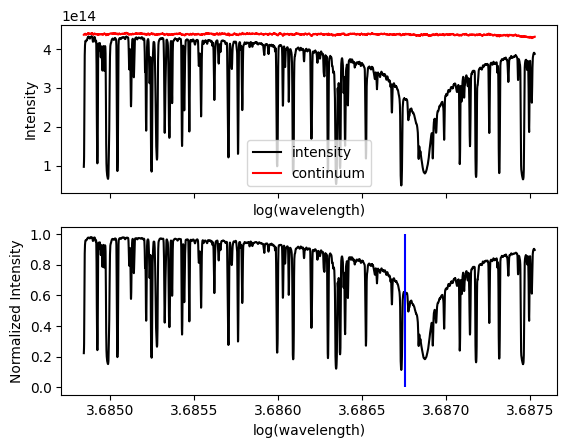

In [4]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(log_wave, y[:,0], color='black', label='intensity')
axs[0].plot(log_wave, y[:,1], color='red', label='continuum')
axs[1].plot(log_wave, y[:,0]/y[:,1], color='black')
axs[1].vlines(np.log10(4861.35), 0, 1, color='blue', label='Hbeta')
# axs[1].vlines(np.log10(10049.8), 0, 1, color='red', label='Halpha')
# axs[1].vlines(np.log10(10938.17 ), 0, 1, color='blue', label='Halpha')
# axs[1].vlines(np.log10(3021.08), 0, 1, color='blue', label='Fe')
# axs[1].vlines(np.log10(3000.0)- 0.000119, 0, 1, color='blue', label='Fe')
# axs[1].vlines(np.log10(11000.0), 0, 1, color='blue', label='Fe')
axs[0].set_xlabel("log(wavelength)")
axs[0].set_ylabel("Intensity")
axs[1].set_xlabel("log(wavelength)")
axs[1].set_ylabel("Normalized Intensity")
axs[0].legend()

plt.show()

In [24]:
np.linspace(np.log10(3000), np.log10(11000), 400000)

array([3.47712125, 3.47712267, 3.47712408, ..., 4.04138986, 4.04139127,
       4.04139269])

In [30]:
import jax.numpy as jnp
jnp.linspace(np.log10(3000), np.log10(11000), 400000)

Array([3.4771214, 3.4771228, 3.4771242, ..., 4.04139  , 4.0413914,
       4.041393 ], dtype=float32)

In [20]:
import h5py
import numpy as np
import glob
import os

def read_hdf5_file(filename: str):
    with h5py.File(filename, 'r') as file:
        # Reading scalar attributes
        Teff = file['Teff'][()]
        logg = file['logg'][()]
        Fe_M = file['Fe_M'][()]
        alpha_M = file['alpha_M'][()]
        C_M = file['C_M'][()]
        vmic = file['vmic'][()]
        
        # Reading arrays
        mu_points = np.array(file['mu_points'])
        random_abundances = np.array(file['random_abundances'])
        log_wave_lines = np.array(file['log_wave_lines'])
        flux = np.array(file['flux'], dtype=np.float32)  # Ensures float32 type
        intensities = np.array(file['intensities'], dtype=np.float32)  # Ensures float32 type
        log_wave_cont = np.array(file['log_wave_cont'])
        flux_cont = np.array(file['flux_cont'], dtype=np.float32)  # Ensures float32 type
        intensities_cont = np.array(file['intensities_cont'], dtype=np.float32)  # Ensures float32 type
        
        # Returning data in a structured way
        return {
            "attributes": {
                "Teff": Teff,
                "logg": logg,
                "Fe_M": Fe_M,
                "alpha_M": alpha_M,
                "C_M": C_M,
                "vmic": vmic,
            },
            "arrays": {
                "mu_points": mu_points,
                "random_abundances": random_abundances,
                "log_wave_lines": log_wave_lines,
                "flux": flux,
                "intensities": intensities,
                "log_wave_cont": log_wave_cont,
                "flux_cont": flux_cont,
                "intensities_cont": intensities_cont,
            }
        }

METALS_SYMBOLS = ["Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U"
]

ALPHA_AND_OXYGEN_SYMBOLS = ["Ne", "Mg", "Si", "S", "Ar", "Ca", "Ti", "O"]

ATOMIC_SYMBOLS = ["He"] + METALS_SYMBOLS

def process_spectrum(spectrum):
    # preprocess the data into intensities fluxes and wavelengths
    no_parameters = 3 # Teff, logg, vmic (Fe_M, alpha_M, C_M will be incorporated in the abundances)
    no_mus = spectrum["arrays"]["mu_points"].shape[0]
    no_abundances = spectrum["arrays"]["random_abundances"].shape[0]
    no_wavelengths_lines = spectrum["arrays"]["log_wave_lines"].shape[0]
    no_wavelengths_cont = spectrum["arrays"]["log_wave_cont"].shape[0]

    # ----------------------------------------------------------------------------------
    # Process abundances:
    abundances = spectrum["arrays"]["random_abundances"]

    # Incorporate the Fe_M into the other abundances (all except He):
    abundances[1:] += spectrum["attributes"]["Fe_M"] 

    # Incorporate the alpha_M into the alpha and oxygen elements:
    for element in ALPHA_AND_OXYGEN_SYMBOLS:
        element_index = ATOMIC_SYMBOLS.index(element)
        abundances[element_index] += spectrum["attributes"]["alpha_M"] 

    # Incorporate the C_M into the C element:
    C_index = ATOMIC_SYMBOLS.index("C")
    abundances[C_index] += spectrum["attributes"]["C_M"]
    # Abundances are now ready to be used
    # ----------------------------------------------------------------------------------

    # Deal with parmeters: 
    parameters = np.zeros((3 + no_abundances)) #and then reshape:
    parameters[0] = np.log10(spectrum["attributes"]["Teff"])
    parameters[1] = spectrum["attributes"]["logg"]
    parameters[2] = spectrum["attributes"]["vmic"]
    parameters[3:] = abundances

    # Now I need a matrix of parameters
    parameters = parameters[None,:].repeat(no_mus, axis=0)
    parameters = np.concatenate((parameters, spectrum["arrays"]["mu_points"][:,None]), axis=1)

    # check that the parameters are correct:
    # np.isclose(parameters[:,0], spectrum["attributes"]["Teff"]).all()
    # np.isclose(parameters[:,1], spectrum["attributes"]["logg"]).all()
    # np.isclose(parameters[:,2], spectrum["attributes"]["vmic"]).all()
    # np.isclose(parameters[:,3:-1], abundances).all()
    # np.isclose(parameters[:,-1], spectrum["arrays"]["mu_points"]).all()
    

    intensities = spectrum["arrays"]["intensities"].T
    intensities_cont = spectrum["arrays"]["intensities_cont"].T

    # check intensities:
    # np.isclose(intensities, spectrum["arrays"]["intensities"].T).all()
    # np.isclose(intensities_cont, spectrum["arrays"]["intensities_cont"].T).all()

    
    # Normalize the intensities dividing by interpolated intensities_cont:
    log_wave_cont = spectrum["arrays"]["log_wave_cont"]
    log_wave_lines = spectrum["arrays"]["log_wave_lines"]
    for i in range(no_mus):
        cntm = np.interp(log_wave_lines, log_wave_cont, intensities_cont[i])
        intensities[i] = intensities[i] / cntm

    # Execute the check
    valid_intensities = np.all(np.isfinite(intensities) & (intensities > 0), axis=1)

    return parameters, valid_intensities, log_wave_lines, intensities, log_wave_cont, intensities_cont

In [72]:
ref_spectrum = read_hdf5_file(".cache/star_000001.h5")
ref_parameters, valid_intensities, log_wave_lines, intensities, log_wave_cont, intensities_cont = process_spectrum(ref_spectrum)

# ---
idx = 29
ref_mu = np.array([ref_parameters[idx,-1]])
ref_params = model.from_relative_parameters(ref_parameters[29,:-1])

min_wave = np.log10(4840)
max_wave = np.log10(4870)
mask = ( log_wave_lines > min_wave ) & ( log_wave_lines < max_wave )
log_wave = log_wave_lines[mask]
ref_lines = intensities[idx, mask]
ref_continuum = np.interp(log_wave, log_wave_cont, intensities_cont[idx])
ref_lines *= ref_continuum
print(log_wave.shape, ref_lines.shape, ref_continuum.shape)

(1903,) (1903,) (1903,)


In [73]:
y_pred = model(log_wave, ref_mu,  ref_params)

In [74]:
pred_continuum, pred_lines = y_pred[:,1], y_pred[:,0]

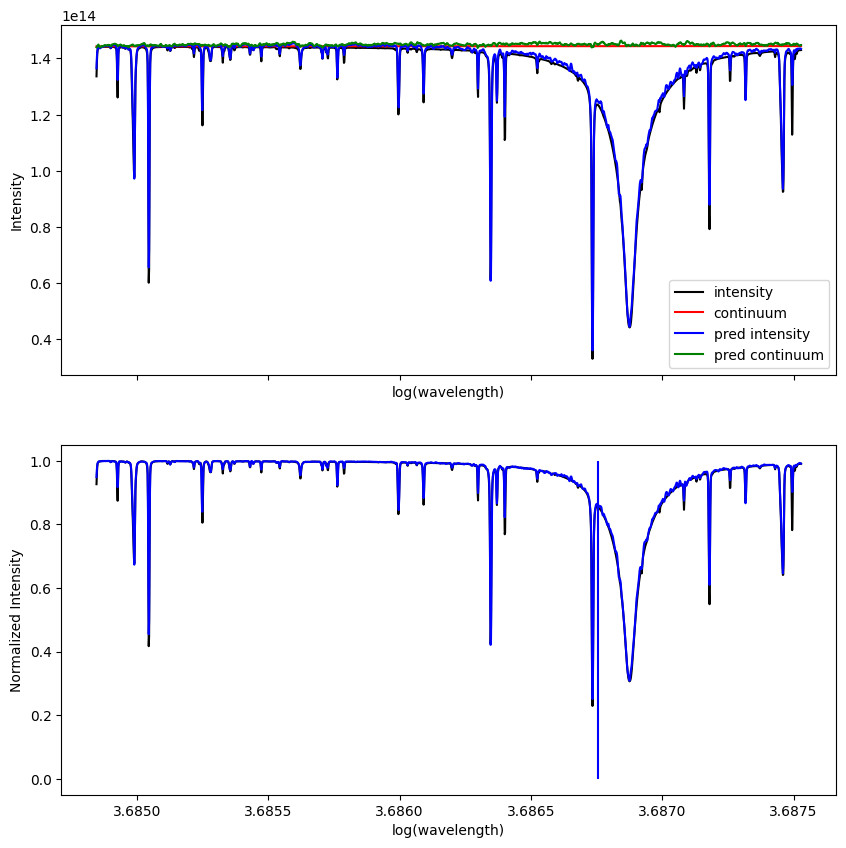

In [75]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 10))
axs[0].plot(log_wave, ref_lines, color='black', label='intensity')
axs[0].plot(log_wave, ref_continuum, color='red', label='continuum')
axs[0].plot(log_wave, pred_lines, color='blue', label='pred intensity')
axs[0].plot(log_wave, pred_continuum, color='green', label='pred continuum')
axs[1].plot(log_wave, ref_lines/ref_continuum, color='black')
axs[1].plot(log_wave, pred_lines/pred_continuum, color='blue')
axs[1].vlines(np.log10(4861.35), 0, 1, color='blue', label='Hbeta')
axs[0].set_xlabel("log(wavelength)")
axs[0].set_ylabel("Intensity")
axs[1].set_xlabel("log(wavelength)")
axs[1].set_ylabel("Normalized Intensity")
axs[0].legend()